# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from pathlib import Path

from PIL import Image
from google import genai

import tt

LOG = logging.getLogger(__name__)
tt.logging_init()

In [ ]:
CLASSES = [
    "chicken",
    "cow",
    "creeper",
    "enderman",
    "pig",
    "sheep",
    "skeleton",
    "spider",
    "villager",
    "zombie",
]
CLASSES.sort()
CLASSES_MINECRAFT = [f"minecraft {x}" for x in CLASSES]

flash = "gemini-2.5-flash"
flash_lite = "gemini-2.5-flash-lite"
prompt_short = f"""Detect {", ".join(CLASSES)}. Return AT MOST 20 detections."""

mobs_path = Path.home() / "src/data/mobs1/640"

# File upload

In [ ]:
GF = tt.GeminiFileAPI()
# GF.upload_dir(mobs_path)
GF.sync()
print(GF.gfiles)

[20:13:14]:[INFO]:(httpx): HTTP Request: GET https://generativelanguage.googleapis.com/v1beta/files "HTTP/1.1 200 OK"
[20:13:15]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/upload/v1beta/files "HTTP/1.1 200 OK"
[20:13:16]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/upload/v1beta/files?upload_id=AOCedOHPiC26qQTRHwMZuA4azQIcbcloWQ-3mpGeFMv6GUp728-TPNZeoHz4vCl0AKaSWnGaJXo5peLwFVQKsfN0vOXkwO-lyKUk_EjkTwWqABo&upload_protocol=resumable "HTTP/1.1 200 OK"
[20:13:17]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/upload/v1beta/files "HTTP/1.1 200 OK"
[20:13:18]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/upload/v1beta/files?upload_id=AOCedOGeMbq1RNRO6YSEalyWnCsNPre8b_VITmMy4-V7haOt2LQnB-bOtHrCZEp6zpyfmozeoTPEH3LXki2ctsvceD83TKBM9t947myfnly4Nis&upload_protocol=resumable "HTTP/1.1 200 OK"
[20:13:19]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapi

[File(
  create_time=datetime.datetime(2025, 11, 5, 1, 14, 34, 901789, tzinfo=TzInfo(0)),
  display_name='/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png',
  expiration_time=datetime.datetime(2025, 11, 7, 1, 14, 34, 705904, tzinfo=TzInfo(0)),
  mime_type='image/png',
  name='files/4nwa3g6ni1f9',
  sha256_hash='NjEyMmFkN2ExZjk3NTUwZWRkMzczZjcxN2ZiYzkyMTBjMjJiMjhhODRkNmE0MjEzYTE4NzVjYTQxNzJiZmI3ZA==',
  size_bytes=467090,
  source=<FileSource.UPLOADED: 'UPLOADED'>,
  state=<FileState.ACTIVE: 'ACTIVE'>,
  update_time=datetime.datetime(2025, 11, 5, 1, 14, 34, 901789, tzinfo=TzInfo(0)),
  uri='https://generativelanguage.googleapis.com/v1beta/files/4nwa3g6ni1f9'
), File(
  create_time=datetime.datetime(2025, 11, 5, 1, 14, 33, 435829, tzinfo=TzInfo(0)),
  display_name='/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png',
  expiration_time=datetime.datetime(2025, 11, 7, 1, 14, 33, 148080, tzinfo=TzInfo(0)),
  mime_type='image/png',
  name='files/cyr911keitti',
  sha2

# 

# Detect

[20:18:20]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:18:23]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
[20:18:23]:[INFO]:(tt): RESPONSE len=219 [
  {"box_2d": [323, 539, 406, 634], "label": "spider"},
  {"box_2d": [390, 517, 444, 554], "label": "chicken"},
  {"box_2d": [323, 608, 359, 646], "label": "pig"},
  {"box_2d": [471, 289, 577, 357], "label": "sheep"}
]


[BBox(xyxyn=(0.539, 0.323, 0.634, 0.406), label='spider'), BBox(xyxyn=(0.517, 0.39, 0.554, 0.444), label='chicken'), BBox(xyxyn=(0.608, 0.323, 0.646, 0.359), label='pig'), BBox(xyxyn=(0.289, 0.471, 0.357, 0.577), label='sheep')]


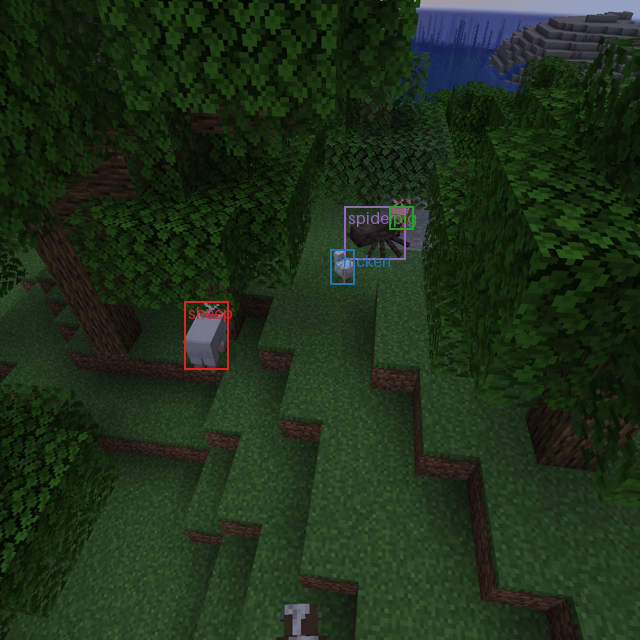

[20:18:23]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:18:26]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[20:18:26]:[INFO]:(tt): RESPONSE len=219 [
  {"box_2d": [359, 475, 452, 550], "label": "chicken"},
  {"box_2d": [419, 212, 572, 350], "label": "sheep"},
  {"box_2d": [300, 562, 400, 642], "label": "pig"},
  {"box_2d": [298, 562, 400, 642], "label": "spider"}
]


[BBox(xyxyn=(0.475, 0.359, 0.55, 0.452), label='chicken'), BBox(xyxyn=(0.212, 0.419, 0.35, 0.572), label='sheep'), BBox(xyxyn=(0.562, 0.3, 0.642, 0.4), label='pig'), BBox(xyxyn=(0.562, 0.298, 0.642, 0.4), label='spider')]


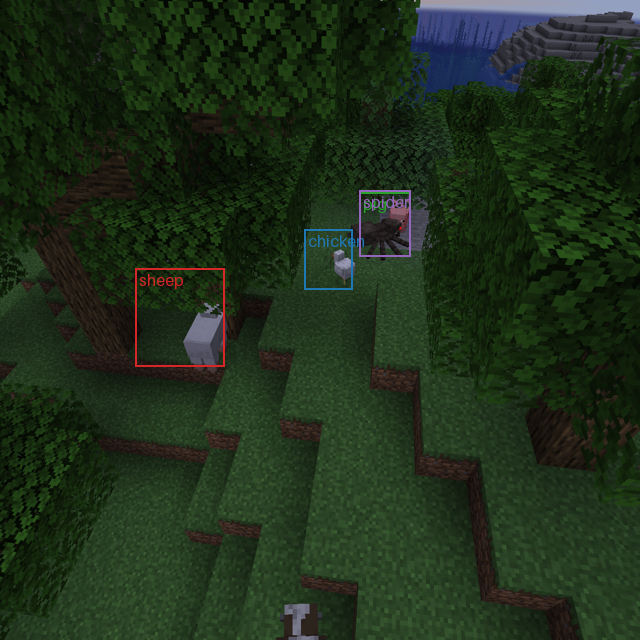

In [6]:
# image640 = Image.open(mobs_path / "06092b21-2024-10-20_22.22.09.png")
# image640 = Image.open(sorted(mobs_path.glob("*.png"))[5])
# This image causes gemini-2.5-flash-lite to detect the pig repeatedly.
image_break = "/Users/joe/src/data/mobs1/640/cda62cfe-2024-10-20_22.22.31.png"
image640 = Image.open(image_break)
# display(image640)
bbox = tt.gemini_detect(image640, prompt_short, model=flash, temperature=0.1)
print(bbox)
display(tt.plot_bb(image640, bbox, CLASSES))

bbox = tt.gemini_detect(image640, prompt_short, model=flash_lite, temperature=0.1)
print(bbox)
display(tt.plot_bb(image640, bbox, CLASSES))

In [ ]:
def detect_gfiles(gf: genai.types.File) -> tuple[Image.Image, str]:
    assert isinstance(gf.display_name, str)
    image_file = gf.display_name
    bbs = tt.gemini_detect(gf, prompt_short)
    ann_image = tt.plot_bb(Image.open(image_file), bbs, CLASSES)
    return ann_image, image_file
    
GF.sync()
tt.InferViewer[genai.types.File](detect_gfiles, GF.gfiles).show_widget()

In [9]:
def result2image(result: tt.ImageResult) -> tuple[Image.Image, str]:
    ann_image = tt.plot_bb(Image.open(result.file), result.bboxes, CLASSES)
    return ann_image, result.file

GFILES10 = GF.gfiles[:10]

In [ ]:
tt.InferViewer[tt.ImageResult](
    result2image,
    tt.gemini_detect_multi(GFILES10, prompt=prompt_short, model=flash, temperature=0.0),
).show_widget()

  0%|          | 0/10 [00:00<?, ?it/s][20:26:49]:[INFO]:(tt): Detect 1/10 file=/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png
[20:26:49]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:26:50]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
[20:26:50]:[INFO]:(tt): RESPONSE len=56 [
  {"box_2d": [167, 249, 533, 554], "label": "sheep"}
]
 10%|█         | 1/10 [00:01<00:14,  1.62s/it][20:26:50]:[INFO]:(tt): Detect 2/10 file=/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png
[20:26:51]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:26:52]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
[20:26:52]:[INFO]:(tt): RESPONSE len=104 [
  {"box_2d": [484, 0, 709, 301], "label": "pig"},
  {"box_2d": [395, 596, 439, 645], "label": "c

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=9), Output()), _do…

In [ ]:
tt.InferViewer[tt.ImageResult](
    result2image,
    tt.gemini_detect_multi(GFILES10, prompt=prompt_short, model=flash_lite, temperature=0.0),
).show_widget()

  0%|          | 0/10 [00:00<?, ?it/s][20:27:56]:[INFO]:(tt): Detect 1/10 file=/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png
[20:27:56]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:27:57]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[20:27:57]:[INFO]:(tt): RESPONSE len=56 [
  {"box_2d": [169, 245, 540, 557], "label": "sheep"}
]
 10%|█         | 1/10 [00:01<00:09,  1.07s/it][20:27:57]:[INFO]:(tt): Detect 2/10 file=/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png
[20:27:57]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:27:58]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[20:27:58]:[INFO]:(tt): RESPONSE len=153 [
  {"box_2d": [417, 0, 487, 54], "label": "pig"},
  {"box_2d": [487, 0, 708, 304], "lab

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=9), Output()), _do…

In [12]:
temp = 0.1
print("FLASH")
tt.InferViewer[tt.ImageResult](
    result2image,
    tt.gemini_detect_multi(GFILES10, prompt=prompt_short, model=flash, temperature=temp),
).show_widget()

print("FLASH-LITE")
tt.InferViewer[tt.ImageResult](
    result2image,
    tt.gemini_detect_multi(GFILES10, prompt=prompt_short, model=flash_lite, temperature=temp),
).show_widget()

FLASH


  0%|          | 0/10 [00:00<?, ?it/s][20:31:13]:[INFO]:(tt): Detect 1/10 file=/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png
[20:31:13]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:31:14]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
[20:31:14]:[INFO]:(tt): RESPONSE len=56 [
  {"box_2d": [168, 250, 535, 555], "label": "sheep"}
]
 10%|█         | 1/10 [00:01<00:10,  1.16s/it][20:31:14]:[INFO]:(tt): Detect 2/10 file=/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png
[20:31:14]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:31:16]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
[20:31:16]:[INFO]:(tt): RESPONSE len=104 [
  {"box_2d": [486, 0, 709, 302], "label": "pig"},
  {"box_2d": [395, 594, 439, 646], "label": "c

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=9), Output()), _do…

FLASH-LITE


  0%|          | 0/10 [00:00<?, ?it/s][20:31:27]:[INFO]:(tt): Detect 1/10 file=/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png
[20:31:27]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:31:28]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[20:31:28]:[INFO]:(tt): RESPONSE len=56 [
  {"box_2d": [168, 248, 542, 558], "label": "sheep"}
]
 10%|█         | 1/10 [00:00<00:07,  1.17it/s][20:31:28]:[INFO]:(tt): Detect 2/10 file=/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png
[20:31:28]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:31:29]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[20:31:29]:[INFO]:(tt): RESPONSE len=205 [
  {"box_2d": [416, 0, 485, 56], "label": "pig"},
  {"box_2d": [487, 0, 710, 304], "lab

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=9), Output()), _do…

In [ ]:
temp = None
print("FLASH")
tt.InferViewer[tt.ImageResult](
    result2image,
    tt.gemini_detect_multi(GFILES10, prompt=prompt_short, model=flash, temperature=temp),
).show_widget()

print("FLASH-LITE")
tt.InferViewer[tt.ImageResult](
    result2image,
    tt.gemini_detect_multi(GFILES10, prompt=prompt_short, model=flash_lite, temperature=temp),
).show_widget()

FLASH


  0%|          | 0/10 [00:00<?, ?it/s][20:32:44]:[INFO]:(tt): Detect 1/10 file=/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png
[20:32:44]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:32:45]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
[20:32:45]:[INFO]:(tt): RESPONSE len=56 [
  {"box_2d": [163, 245, 529, 563], "label": "sheep"}
]
 10%|█         | 1/10 [00:01<00:10,  1.12s/it][20:32:45]:[INFO]:(tt): Detect 2/10 file=/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png
[20:32:45]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:32:47]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
[20:32:47]:[INFO]:(tt): RESPONSE len=104 [
  {"box_2d": [486, 0, 701, 298], "label": "pig"},
  {"box_2d": [392, 584, 432, 638], "label": "c

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=9), Output()), _do…

FLASH-LITE


  0%|          | 0/10 [00:00<?, ?it/s][20:32:58]:[INFO]:(tt): Detect 1/10 file=/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png
[20:32:58]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:32:59]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[20:32:59]:[INFO]:(tt): RESPONSE len=56 [
  {"box_2d": [164, 244, 576, 558], "label": "sheep"}
]
 10%|█         | 1/10 [00:01<00:11,  1.28s/it][20:32:59]:[INFO]:(tt): Detect 2/10 file=/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png
[20:32:59]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:33:00]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[20:33:00]:[INFO]:(tt): RESPONSE len=257 [
  {"box_2d": [409, 0, 500, 55], "label": "pig"},
  {"box_2d": [387, 555, 435, 593], "l

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=9), Output()), _do…

In [14]:
temp = 0.3
print("FLASH")
tt.InferViewer[tt.ImageResult](
    result2image,
    tt.gemini_detect_multi(GFILES10, prompt=prompt_short, model=flash, temperature=temp),
).show_widget()

print("FLASH-LITE")
tt.InferViewer[tt.ImageResult](
    result2image,
    tt.gemini_detect_multi(GFILES10, prompt=prompt_short, model=flash_lite, temperature=temp),
).show_widget()

FLASH


  0%|          | 0/10 [00:00<?, ?it/s][20:34:54]:[INFO]:(tt): Detect 1/10 file=/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png
[20:34:54]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:34:55]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
[20:34:55]:[INFO]:(tt): RESPONSE len=56 [
  {"box_2d": [166, 247, 535, 555], "label": "sheep"}
]
 10%|█         | 1/10 [00:01<00:13,  1.48s/it][20:34:55]:[INFO]:(tt): Detect 2/10 file=/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png
[20:34:56]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:34:57]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
[20:34:57]:[INFO]:(tt): RESPONSE len=104 [
  {"box_2d": [486, 0, 709, 301], "label": "pig"},
  {"box_2d": [395, 597, 439, 646], "label": "c

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=9), Output()), _do…

FLASH-LITE


  0%|          | 0/10 [00:00<?, ?it/s][20:35:07]:[INFO]:(tt): Detect 1/10 file=/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png
[20:35:07]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:35:08]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[20:35:08]:[INFO]:(tt): RESPONSE len=56 [
  {"box_2d": [169, 250, 548, 558], "label": "sheep"}
]
 10%|█         | 1/10 [00:00<00:07,  1.27it/s][20:35:08]:[INFO]:(tt): Detect 2/10 file=/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png
[20:35:08]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:35:09]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[20:35:09]:[INFO]:(tt): RESPONSE len=104 [
  {"box_2d": [359, 558, 433, 650], "label": "cow"},
  {"box_2d": [417, 0, 708, 302], "

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=9), Output()), _do…

In [ ]:
temp = 0.5
print("FLASH")
tt.InferViewer[tt.ImageResult](
    result2image,
    tt.gemini_detect_multi(GFILES10, prompt=prompt_short, model=flash, temperature=temp),
).show_widget()

print("FLASH-LITE")
tt.InferViewer[tt.ImageResult](
    result2image,
    tt.gemini_detect_multi(GFILES10, prompt=prompt_short, model=flash_lite, temperature=temp),
).show_widget()

FLASH


  0%|          | 0/10 [00:00<?, ?it/s][20:48:36]:[INFO]:(tt): Detect 1/10 file=/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png
[20:48:36]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:48:38]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
[20:48:38]:[INFO]:(tt): RESPONSE len=56 [
  {"box_2d": [168, 250, 535, 555], "label": "sheep"}
]
 10%|█         | 1/10 [00:01<00:13,  1.46s/it][20:48:38]:[INFO]:(tt): Detect 2/10 file=/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png
[20:48:38]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:48:39]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
[20:48:39]:[INFO]:(tt): RESPONSE len=104 [
  {"box_2d": [486, 0, 709, 301], "label": "pig"},
  {"box_2d": [395, 597, 439, 646], "label": "c

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=9), Output()), _do…

FLASH-LITE


  0%|          | 0/10 [00:00<?, ?it/s][20:48:49]:[INFO]:(tt): Detect 1/10 file=/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png
[20:48:49]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:48:49]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[20:48:49]:[INFO]:(tt): RESPONSE len=56 [
  {"box_2d": [169, 254, 536, 558], "label": "sheep"}
]
 10%|█         | 1/10 [00:00<00:06,  1.31it/s][20:48:49]:[INFO]:(tt): Detect 2/10 file=/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png
[20:48:49]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[20:48:51]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[20:48:51]:[INFO]:(tt): RESPONSE len=153 [
  {"box_2d": [404, 0, 485, 53], "label": "pig"},
  {"box_2d": [491, 0, 709, 302], "lab

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=9), Output()), _do…